# CS217 : Assignment 2  :  Structure From Motion

---
Please edit the cell below to include your name and student ID #

**name:** Saad Manzur

**SID:** 83166813

# 1. Feature Matching

## 1.1  SIFT matching library

Install an implementation of SIFT-based feature matching; I recommend using the one integrated into opencv-python. However, getting it installed is a little bit tricky because the algorithm is patented so it isn't included with some distributions. I used the recipe below to install on my system.

**conda install opencv**

**pip install opencv-contrib-python==3.4.2.16**


I have provided some example code below exercising the OpenCV SIFT matching functions. Once you are comfortable with this, please implement a function which takes as input the two images and returns the coordinates for the candidate matching points for use in the remainder of the assignment. If you decide not to use OpenCV then you should implement this function to wrap whatever version of SIFT you use.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import cv2 as opencv

# you can use matplotlib notebook during development but
# when you print out your notebook as pdf there may be 
# problems with figures displaying so you may want to switch
# to inline
%matplotlib inline

In [3]:
#
# Example code exercising the OpenCV library matching functions
#

# load in images, convert to grayscale, resize
img1 = opencv.imread('data/G.jpg')
img1 = opencv.cvtColor(img1,opencv.COLOR_RGB2BGR)
gray1= opencv.cvtColor(img1,opencv.COLOR_BGR2GRAY)
dim = (0.4*np.asarray(gray1.shape)).astype(int)
gray1 = opencv.resize(gray1,(dim[1],dim[0]))

img2 = opencv.imread('data/H.jpg')
img2 = opencv.cvtColor(img2,opencv.COLOR_RGB2BGR)
gray2= opencv.cvtColor(img2,opencv.COLOR_BGR2GRAY
dim = (0.4*np.asarray(gray2.shape)).astype(int)
gray2 = opencv.resize(gray2,(dim[1],dim[0]))


# extract SIFT feature descriptors and keypoints from each image
sift = opencv.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1,None)
kp2, des2 = sift.detectAndCompute(gray2,None)

# visualize SIFT features
vis1=opencv.drawKeypoints(gray1,kp1,None,flags=opencv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis2=opencv.drawKeypoints(gray2,kp2,None,flags=opencv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.rcParams['figure.figsize'] = [15,15]
plt.imshow(vis1)
plt.show()
plt.imshow(vis2)
plt.show()

# perform matching to find the 2 nearest neighbors for each descriptor
bf = opencv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# only keep a match if the distance to the 1st match is significantly
# less than the distance to the second match
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

        
# Visualize the resulting matches. You may wish to write out the image to
# a file or open in a separate window to view at higher resolution.
img3 = opencv.drawMatchesKnn(gray1,kp1,gray2,kp2,good[:8],None)
plt.imshow(img3)
plt.show()


SyntaxError: invalid syntax (<ipython-input-3-f91daffae351>, line 15)

In [4]:
def getMatches(img1,img2):
    """
    Given two grayscale images, return a set of candidate matches using SIFT keypoint matching 
    
    Parameters
    ----------
    img1 : 2D numpy.array 
    img2 : 2D numpy.array 
            Grayscale images to match

    Returns
    -------
    pts1 : 2D numpy.array (dtype=float)
    pts2 : 2D numpy.array (dtype=float)
        Candidate pairs of matching points from img1 and img2 stored in arrays of shape (2,N)
        
    
    """
    sift = opencv.xfeatures2d.SIFT_create()
    keypoints1, descriptor1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptor2 = sift.detectAndCompute(img2, None)
    
    bf = opencv.BFMatcher()
    matches = bf.knnMatch(descriptor1, descriptor2, k=2)
    
    pts1 = []
    pts2 = []
    kpts1 = []
    kpts2 = []
    good = []
    for m, n in matches:
        if m.distance < 0.75*n.distance:
            pts2.append(keypoints2[m.trainIdx].pt)
            pts1.append(keypoints1[m.queryIdx].pt)
            kpts2.append(keypoints2[m.trainIdx])
            kpts1.append(keypoints1[m.queryIdx])
            m.trainIdx = len(pts2)-1
            m.queryIdx = len(pts1)-1
            good.append([m])
            
    pts1 = np.array(pts1)
    pts1 = np.float32(pts1[:, :])
    pts1 = pts1.T
    
    pts2 = np.array(pts2)
    pts2 = np.float32(pts2[:, :])
    pts2 = pts2.T
    
    return (pts1,pts2,kpts1,kpts2,good)

## 1.2 Visualize SIFT candidate matches

Write code below to exercise your **getMatches** function.  Choose a pair of images you want to work with.  I've provided a few examples but you are encouraged to take your own photos or use some images off the web. Visualize the resulting set of candidate matches.  You can either modify your **getMatches** function to also return the **cv2** keypoint data structures and use **cv2.drawMatchesKnn**, or alternately come up with your own visualization technique to show correpsondences.

(2, 56)


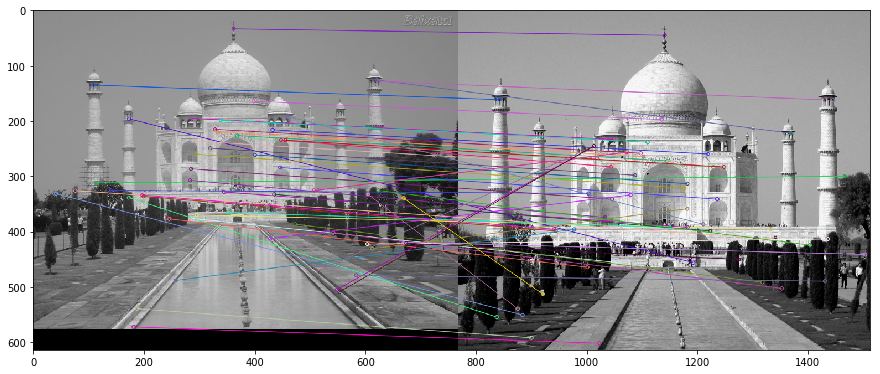

In [47]:
img1 = opencv.imread('data/G.jpg')
img1 = opencv.cvtColor(img1, opencv.COLOR_BGR2RGB)
gray1 = opencv.cvtColor(img1, opencv.COLOR_RGB2GRAY)
dim1 = (0.6*np.asarray(gray1.shape)).astype(int)
gray1 = opencv.resize(gray1, (dim1[1], dim1[0]))

img2 = opencv.imread('data/H.jpg')
img2 = opencv.cvtColor(img2, opencv.COLOR_BGR2RGB)
gray2 = opencv.cvtColor(img2, opencv.COLOR_RGB2GRAY)
dim2 = (0.6*np.asarray(gray2.shape)).astype(int)
gray2 = opencv.resize(gray2, (dim2[1], dim2[0]))

pts1, pts2, kpts1, kpts2, good = getMatches(gray1, gray2)

print(pts1.shape)

img3 = opencv.drawMatchesKnn(gray1,kpts1,gray2,kpts2,good[:56],None)

plt.rcParams['figure.figsize'] = [15,15]
plt.imshow(img3)
plt.show()

# 2. Estimation of the Fundamental Matrix

As you can see from the matching results, SIFT finds matches which are not consistent with a single overall camera
motion. In order to find a consistent set of matches, implement RANSAC to estimate the fundamental matrix F. For
each random sample you should estimate F using the normalized 8 point algorithm (as described in Hartley’s paper
“In defense of ...” linked from the class website and discussed in section 4.4 of Hartley and Zisserman). You will need to experiment with the appropriate error threshold for determining inliers and outliers

In [7]:
def fitFundamentalFromOpenCV(pts2L, pts2R):
    F, mask = opencv.findFundamentalMat(pts2L.T, pts2R.T, opencv.FM_8POINT)
    
    pts2LH = np.vstack((pts2L, np.ones((1,pts2L.shape[1]))))
    pts2RH = np.vstack((pts2R, np.ones((1,pts2R.shape[1]))))
    
    if not isinstance(F, np.ndarray):
        return F, 99999
        
    fiterror = np.average((pts2LH.T @ (F @ pts2RH) )**2)
    
    return F, fiterror
    

def getNormalizationMatrix(pts2):
    mean = np.mean(pts2[:2], axis=1)
    scale = np.sqrt(2) / (np.std(pts2[:2]))**2
    transformation = np.array([[scale, 0, -scale*mean[0]],
                                [0, scale, -scale*mean[1]],
                                [0, 0, 1]])
    return transformation

def fitFundamental(pts2L,pts2R):
    """
    Estimate fundamental matrix from point correspondences in two views 
    
    Parameters
    ----------
    pts2L : 2D numpy.array (dtype=float)
    pts2R : 2D numpy.array (dtype=float)
        Coordinates of N points in the left and right view stored in arrays of shape (2,N)


    Returns
    -------
    F : 2D numpy.array (dtype=float)
        Fundamental matrix of shape (3,3)
        
    fiterror : float
        The quality of the fit measured as the average of (x^T*F*x')^2 over all corresponding points x,x'
    
    """ 
    #Fcv, mask = opencv.findFundamentalMat(pts2L.T, pts2R.T, opencv.FM_8POINT)
    
    if pts2L.shape[1] != pts2R.shape[1]:
        return np.zeros((3,3)), 99999
    
    numberOfPoints = pts2L.shape[1]
    
    pts2L = np.vstack((pts2L, np.ones((1, numberOfPoints))))
    pts2R = np.vstack((pts2R, np.ones((1, numberOfPoints))))
    
    '''
    #Step 1: First do the normalization by doing a translation and isotropic scaling
    meanL = np.mean(pts2L[:2], axis=1)
    scaleL = np.sqrt(2) / (np.std(pts2L[:2]))**2
    transformationL = np.array([[scaleL, 0, -scaleL*meanL[0]],
                                [0, scaleL, -scaleL*meanL[1]],
                                [0, 0, 1]])
    '''
    transformationL = getNormalizationMatrix(pts2L)
    pts2LN = np.dot(transformationL, pts2L)
    
    '''
    meanR = np.mean(pts2R[:2], axis=1)
    scaleR = 1 / (np.std(pts2R[:2]))**2
    transformationR = np.array([[scaleR, 0, -scaleR*meanR[0]],
                               [0, scaleR, -scaleR*meanR[1]],
                               [0, 0, 1]])
    '''
    transformationR = getNormalizationMatrix(pts2R)
    pts2RN = np.dot(transformationR, pts2R)
    
    A = np.zeros((numberOfPoints, 9))
    for i in range(numberOfPoints):
        A[i] = [pts2LN[0,i]*pts2RN[0,i], pts2LN[0,i]*pts2RN[1,i], pts2LN[0,i]*pts2RN[2,i],
                pts2LN[1,i]*pts2RN[0,i], pts2LN[1,i]*pts2RN[1,i], pts2LN[1,i]*pts2RN[2,i],
                pts2LN[2,i]*pts2RN[0,i], pts2LN[2,i]*pts2RN[1,i], pts2LN[2,i]*pts2RN[2,i]]
        
    U, E, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3,3)
    
    U, E, Vt = np.linalg.svd(F)
    E[-1] = 0
    F = U @ np.diag(E) @ Vt
    F = F/F[2,2]
    
    F = np.dot(transformationR.T, np.dot(F, transformationL))
    F = F/F[2,2]
    
    fiterror = (pts2L.T @ F @ pts2R)**2
    fiterror = np.average(fiterror)
    
    return (F,fiterror)


In [37]:
#
#  I recommend debugging / testing your fitting function with some synthetic example
#  where you know what the "true" F matrix is. You can do this by generating points 
#  from two views using the project function from Assignment #1.
#

F, fiterror = fitFundamental(pts1[:,:8], pts2[:,:8])
print(fiterror)
print(F)


2.3238531132703697
[[-3.51982390e-04  4.40921681e-06  3.85688035e-03]
 [-1.77662443e-05 -4.36907325e-07  1.19284133e-03]
 [ 1.66027013e-02 -9.88845702e-04  1.00000000e+00]]


In [90]:
def fitFundamentalRANSAC(pts2L,pts2R,thresh,niter):
    """
    Robust estimation of fundamental matrix from point correspondences in two views 
    
    Parameters
    ----------
    pts2L : 2D numpy.array (dtype=float)
    pts2R : 2D numpy.array (dtype=float)
            Coordinates of N points in the left and right view stored in arrays of shape (2,N)

    thresh : float
        Error threshold to decide whether a point is an inlier or outlier

    niter : int
        Number of RANSAC iterations to run
        
    Returns
    -------
    F : 2D numpy.array (dtype=float)
        Fundamental matrix of shape (3,3)
    
    inliers : numpy.array (dtype=int)
        Indices of the points which were determined to be inliers
        
    fiterror : float
        The quality of the fit measured as the average of (x^T*F*x')^2 over all corresponding points x,x'
    
    """ 
    
    MIN_INLIER_COUNT = 6
    
    maxInlier = 0
    inliers = []
    chosenF = np.zeros((3,3))
    chosenFiterror = 9999
    
    for i in range(niter):
        modelIndices = np.random.choice(pts2L.shape[1], 8, replace=False)
        
        pts2Lmodel = pts2L[:,modelIndices]
        pts2Rmodel = pts2R[:,modelIndices]
        
        pts2Ltest = np.vstack((pts2L, np.ones(pts2L.shape[1])))
        pts2Rtest = np.vstack((pts2R, np.ones(pts2R.shape[1])))
        
        F, fiterror = fitFundamental(pts2Lmodel, pts2Rmodel)
        #F, fiterror = fitFundamentalFromOpenCV(pts2Lmodel, pts2Rmodel)
        
        if not isinstance(F, np.ndarray):
            continue
        
        currentInliers = []
        for j in range(pts2Ltest.shape[1]):
            if j not in modelIndices:
                error = (pts2Ltest[:,j].T @ F @ pts2Rtest[:,j])**2
                
                if error < thresh:
                    currentInliers.append(j)
        
        if len(currentInliers) > MIN_INLIER_COUNT:
            #np.append(np.asarray(currentInliers), modelIndices)
            
            F, fiterror = fitFundamental(pts2L[:,currentInliers], pts2R[:,currentInliers])
            #F, fiterror = fitFundamentalFromOpenCV(pts2L[:,currentInliers], pts2R[:,currentInliers])
            if not isinstance(F, np.ndarray):
                continue
            
            if fiterror < chosenFiterror:
                currentInliers = np.append(np.asarray(currentInliers), modelIndices)
                inliers = currentInliers
                maxInlier = len(currentInliers)
                chosenF = F
                chosenFiterror = fiterror
                print(i, ": ", chosenFiterror)
        
    #print(inliers)
    
    return (chosenF,inliers,chosenFiterror)


In [108]:
#  Again, it is probably good to test your RANSAC function using some toy data.
#  You can add in some random point matches as outliers and see that RANSAC 
#  correctly eliminates them.
#

F, inliers, fiterror = fitFundamentalRANSAC(pts1, pts2, 4e-5, 100000)

99 :  0.07073196170821856
855 :  0.027800748308264633
858 :  0.003284704594736349
1190 :  0.0023571013625402594
6298 :  0.001924833492224272
7577 :  0.0013326873643658506
9723 :  0.0012391870659161953
27920 :  0.0005369715618602544
31381 :  0.0001380634800435117


***
### 2.1 Visualize Correspondences

Using the same image pairs as in Problem 1, show the best set of correspondences chosen by RANSAC as
inliers. If things are working correctly, the correspondences should be more consistent than in Problem 1 since
they all now satisfy the same epipolar constraint. Experiment with the inlier threshold and number of iterations in order to get the best result

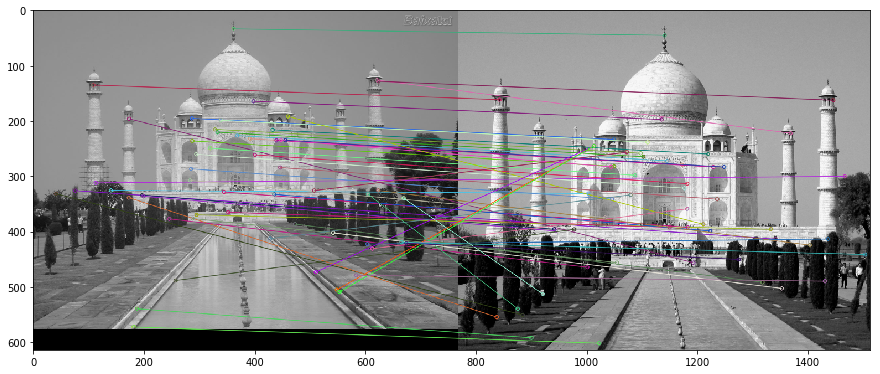

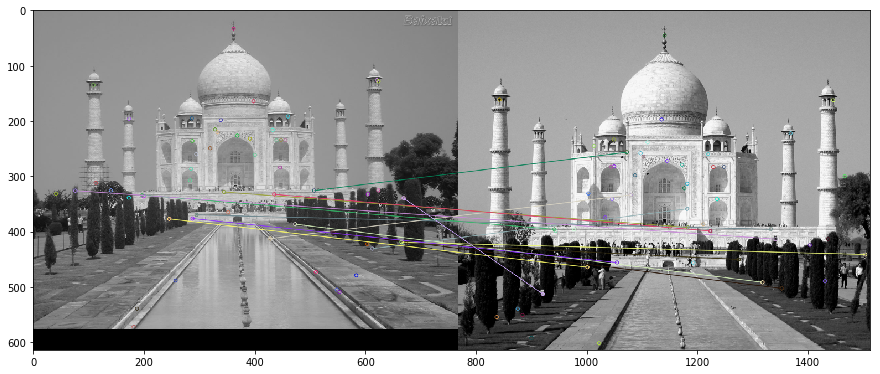

In [109]:
img1 = opencv.imread('data/G.jpg')
img1 = opencv.cvtColor(img1, opencv.COLOR_BGR2RGB)
gray1 = opencv.cvtColor(img1, opencv.COLOR_RGB2GRAY)
dim1 = (0.6*np.asarray(gray1.shape)).astype(int)
gray1 = opencv.resize(gray1, (dim1[1], dim1[0]))

img2 = opencv.imread('data/H.jpg')
img2 = opencv.cvtColor(img2, opencv.COLOR_BGR2RGB)
gray2 = opencv.cvtColor(img2, opencv.COLOR_RGB2GRAY)
dim2 = (0.6*np.asarray(gray2.shape)).astype(int)
gray2 = opencv.resize(gray2, (dim2[1], dim2[0]))

new = []
for i in inliers:
    new.append([good[i][0]])

pts1, pts2, kpts1, kpts2, good = getMatches(gray1, gray2)

img3 = opencv.drawMatchesKnn(gray1,kpts1,gray2,kpts2,new[:],None)

img4 = opencv.drawMatchesKnn(gray1,kpts1,gray2,kpts2,good[:],None)

plt.rcParams['figure.figsize'] = [15,15]
plt.imshow(img4)
plt.show()
plt.imshow(img3)
plt.show()

***
### 2.2  Epipolar Lines

Visualize the epipolar geometry for a subset of 20 feature points in one of your image pairs. For both image
you should plot ~10 feature points along with the epipolar lines on which they should lie given your estimate of $F$ and their corresponding point in the other image. What can you say about the relative pose of the two camera views based on the arrangement of epipolar lines? Can you tell which is the "left" and "right" camera from the lines alone.

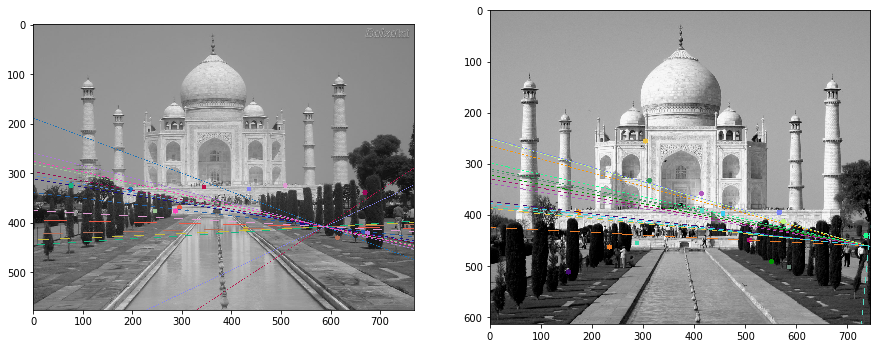

In [110]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = opencv.cvtColor(img1,opencv.COLOR_GRAY2BGR)
    img2 = opencv.cvtColor(img2,opencv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = opencv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = opencv.circle(img1,tuple(pt1),5,color,-1)
        img2 = opencv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

#F, mask  = opencv.findFundamentalMat(pts1.T, pts2.T, opencv.FM_RANSAC, 4e-5, 100000)

inliers1H = np.vstack((pts1[:,inliers], np.ones((1, len(inliers)))))
inliers2H = np.vstack((pts2[:,inliers], np.ones((1, len(inliers)))))

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = opencv.computeCorrespondEpilines(pts2[:,inliers].T.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(gray1,gray2,lines1,pts1[:,inliers].T,pts2[:,inliers].T)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = opencv.computeCorrespondEpilines(pts1[:,inliers].reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(gray2,gray1,lines2,pts2[:,inliers].T,pts1[:,inliers].T)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

### 2.3 Stability 

How stable is your estimate of F? If you rerun RANSAC multiple times with random samplings, does it always
return the same F matrix? Please write a bit of code below to carry out this experiment and compute some quantitative measure of the variability in estimated F. How could you get a more robust estimate?

In [123]:
thresholds = [4e-3, 4e-4, 4e-5, 4e-6]
iterations = [1000, 10000, 100000]

allFs = []
for t in thresholds:
    for n in iterations:
        print(t, ',', n)
        F, inliers, fiterror = fitFundamentalRANSAC(pts1, pts2, t, n)
        allFs.append(F)
    
print("Sum of standard deviations: ", np.sum(np.std(allFs, axis=0)**2))
        

0.004 , 1000
0 :  0.2969161518005713
6 :  0.006748757464880687
8 :  0.00241580468649619
98 :  0.0012725575323171022
516 :  0.0008652625277438562
674 :  0.0004030735138475084
0.004 , 10000
0 :  0.1707793710263504
3 :  0.006644668818810433
9 :  0.0010951805553631616
533 :  0.0010006300342921721
795 :  0.0002501951208172032
1953 :  0.00021779889597131692
0.004 , 100000
0 :  0.008465816062893577
23 :  0.0070228508659889825
62 :  0.00366773873978347
72 :  0.00111076097258975
98 :  0.0010213645214702406
820 :  0.00010083647571223945
23771 :  6.372256075723769e-05
32900 :  5.984806707574395e-06
0.0004 , 1000
1 :  0.22586987741376072
14 :  0.07045934515683229
30 :  0.0018754466426721382
309 :  0.0007286891560245177
557 :  0.000577021415824179
0.0004 , 10000
8 :  0.045796768887758126
12 :  0.0009999782262988695
864 :  0.0009915106826620008
1162 :  0.0005521225428308846
1264 :  0.0005057126561769461
2114 :  0.0004344202781410752
3118 :  0.0004241187760365653
3741 :  0.00039112926978756207
4393 :

# 3. Calibrated Structure From Motion



Download the calibration images provided (sfm.zip). Modify the provided camera calibration script **calibrate.py** as needed and use it to estimate the intrinsic parameter matrix K and enter the results below.

In [16]:
K = np.array([[1.66278079e+03, 0.00000000e+00, 8.38090758e+02],
 [0.00000000e+00, 1.66268979e+03, 6.06617825e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

print(K.shape)
print(K)

(3, 3)
[[1.66278079e+03 0.00000000e+00 8.38090758e+02]
 [0.00000000e+00 1.66268979e+03 6.06617825e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### 3.1 Estimate the Essential Matrix

Write code which loads in the pair of test images, use your SIFT matching routine to return a set of matching points.  Normalize these point coordinates using $K^{-1}$ and then modify your code from Problem 2 to recover the essential matrix E. Remember that you can still use the 8 point algorithm but now you will need to set the two singular values to be equal instead of just zeroing out the smallest singular value. 

[[  4.38987586 -22.71222428  -2.65090589]
 [ 22.47262285   5.67085733  10.3901971 ]
 [  7.21961806 -10.07647091   1.        ]]


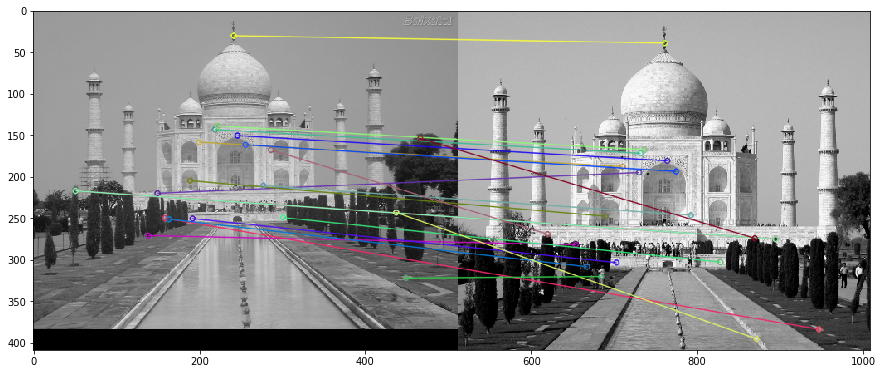

In [18]:
def getEssentialMatrix(pts2L,pts2R, K):
    
    if pts2L.shape[1] != pts2R.shape[1]:
        return np.zeros((3,3)), 99999
    
    numberOfPoints = pts2L.shape[1]
    
    pts2L = np.vstack((pts2L, np.ones((1, numberOfPoints))))
    pts2R = np.vstack((pts2R, np.ones((1, numberOfPoints))))
    
    invK = np.linalg.inv(K)
    
    pts2LN = invK @ pts2L
    pts2RN = invK @ pts2R
    
    A = np.zeros((numberOfPoints, 9))
    for i in range(numberOfPoints):
        A[i] = [pts2LN[0,i]*pts2RN[0,i], pts2LN[0,i]*pts2RN[1,i], pts2LN[0,i]*pts2RN[2,i],
                pts2LN[1,i]*pts2RN[0,i], pts2LN[1,i]*pts2RN[1,i], pts2LN[1,i]*pts2RN[2,i],
                pts2LN[2,i]*pts2RN[0,i], pts2LN[2,i]*pts2RN[1,i], pts2LN[2,i]*pts2RN[2,i]]
        
    U, S, Vt = np.linalg.svd(A)
    E = Vt[-1].reshape(3,3)
    
    U, S, Vt = np.linalg.svd(E)
    S[-1] = 0
    S[0] = 1
    S[1] = 1
    E = U @ np.diag(S) @ Vt
    E = E/E[2,2]
    
    #E = np.dot(transformationR.T, np.dot(E, transformationL))
    #E = E/E[2,2]
    
    #fiterror = (pts2L.T @ F @ pts2R)**2
    #fiterror = np.average(fiterror)
    
    return E



img1 = opencv.imread('data/G.jpg')
img1 = opencv.cvtColor(img1,opencv.COLOR_RGB2BGR)
gray1= opencv.cvtColor(img1,opencv.COLOR_BGR2GRAY)
dim = (0.4*np.asarray(gray1.shape)).astype(int)
gray1 = opencv.resize(gray1,(dim[1],dim[0]))

img2 = opencv.imread('data/H.jpg')
img2 = opencv.cvtColor(img2,opencv.COLOR_RGB2BGR)
gray2= opencv.cvtColor(img2,opencv.COLOR_BGR2GRAY)
dim = (0.4*np.asarray(gray2.shape)).astype(int)
gray2 = opencv.resize(gray2,(dim[1],dim[0]))

pts1, pts2, kpts1, kpts2, good = getMatches(gray1, gray2)

E = getEssentialMatrix(pts1, pts2, K)

print(E)

img3 = opencv.drawMatchesKnn(gray1,kpts1,gray2,kpts2,good[:56],None)

plt.rcParams['figure.figsize'] = [15,15]
plt.imshow(img3)
plt.show()

### 3.2 Camera Pose from the Esential Matrix

Using the SVD technique we described in class, recover the two possible rotation matrices R and translation vectors t associated with E. Discuss your results. Is the recovered translation reasonable based on what you see in the images?


In [28]:
def decomposeEssentialMatrix(E):
    Rz_pos = np.zeros((3,3))
    Rz_pos[0,1] = 1
    Rz_pos[1,0] = -1
    Rz_pos[2,2] = 1
    
    Rz_neg = np.zeros((3,3))
    Rz_neg[0,1] = -1
    Rz_neg[1,0] = 1
    Rz_neg[2,2] = 1
    
    U, S, Vt = np.linalg.svd(E)
    
    R1 = U @ Rz_pos @ Vt
    R2 = U @ Rz_neg @ Vt
    
    T1 = U @ Rz_pos @ S @ U.T
    T2 = U @ Rz_neg @ S @ U.T
    
    return R1, T1, R2, T2
    
R1, T1, R2, T2 = decomposeEssentialMatrix(E)

print(R1, ",", T1)
print(R2, ",", T2)

[[ 0.98021954  0.1940191  -0.03906712]
 [-0.19713008  0.97467347 -0.10559995]
 [ 0.01758928  0.11121243  0.99364099]] , [ -1.98293783  34.07530514 -13.29950105]
[[-0.65123979 -0.03740757 -0.75794948]
 [ 0.34445165 -0.90454072 -0.25131484]
 [-0.67619509 -0.42474317  0.60195801]] , [  1.98293783 -34.07530514  13.29950105]
